<a href="https://colab.research.google.com/github/paridhika/DDL/blob/main/Latency_cost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edge -> PC Utilization = 0.6
NE ->  CPU Utilization = 0.8
Cloud ->  GPU
Bandwidth Edge to NE (Mbps) = 1000
Bandwidth Edge to Cloud (Mbps) = 300
Bandwidth NE to Cloud (Mbps) = 300
Propagation Edge to NE (sec)= 0.001
Propagation Edge to Cloud (sec) = 0.1


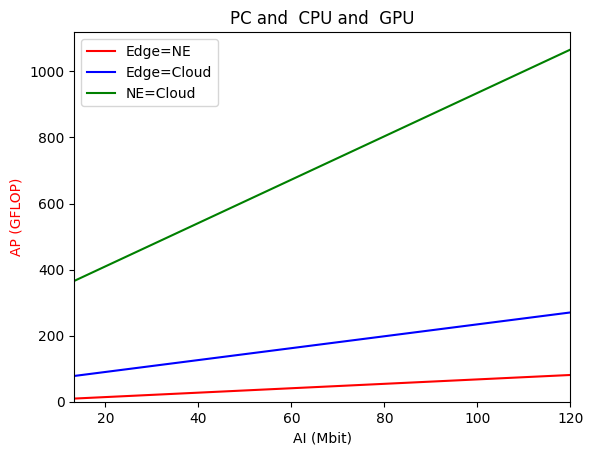

3.4084111111111108e-09 > 1.5785714285714286e-07 > 3.646794871794872e-09
[-0.5828471298037247, -0.7910068190193406, -0.9991665082349566, -1.2073261974505725, -1.4154858866661881, -1.6236455758818042, -1.8318052650974201, -2.039964954313036, -2.248124643528652]
[-24725.537720188266, -25175.092951464416, -25624.648182740566, -26074.203414016716, -26523.758645292866, -26973.313876569016, -27422.869107845167, -27872.424339121317, -28321.979570397467]
[37.63785467378712, 38.124311436557626, 38.61076819932814, 39.09722496209866, 39.583681724869166, 40.07013848763968, 40.5565952504102, 41.043052013180706, 41.52950877595122]


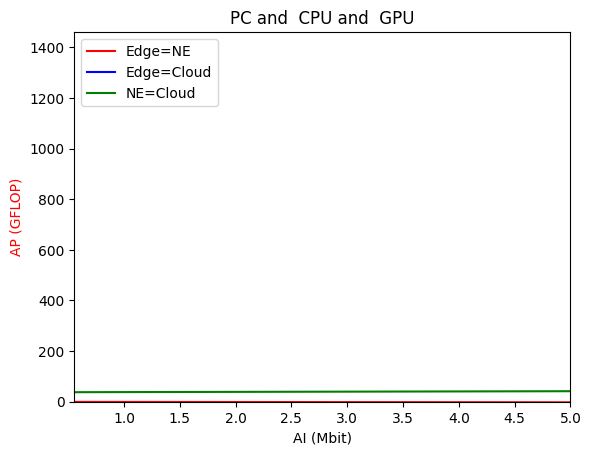

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import csv
locals().clear
globals().clear
class Infrastructure:

    def __init__(self, UtilizationEdge, UtilizationNE, EetoNE, EetoC, NEtoC, PDEtoNE, PDEtoC):
        self.EeP = EeP_Values[edge]
        self.UtilizationEdge = UtilizationEdge
        self.NEnP = ne_ct * NEnP_Values[ne]
        self.UtilizationNE = UtilizationNE
        self.CrP = c_ct * CrP_Values[cloud]
        self.EetoNE = EetoNE
        self.EetoC = EetoC
        self.NEtoC = NEtoC
        self.PDEtoNE = PDEtoNE
        self.PDEtoC = PDEtoC
        self.EeC = EeC_Values[edge]
        self.NEnC = ne_ct * NEnC_Values[ne]
        self.CrC = c_ct * CrC_Values[cloud]
        self.compute_constants()

    def print_configuration(self):
        print("Edge -> " + Device[edge] + " Utilization = " + str(self.UtilizationEdge) )
        print("NE -> " + NE[ne] + " Utilization = " + str(self.UtilizationNE) )
        print("Cloud -> " + Cloud[cloud]  )
        print("Bandwidth Edge to NE (Mbps) = " + str(self.EetoNE))
        print("Bandwidth Edge to Cloud (Mbps) = " + str(self.EetoC))
        print("Bandwidth NE to Cloud (Mbps) = " + str(self.NEtoC))
        print("Propagation Edge to NE (sec)= " + str(self.PDEtoNE))
        print("Propagation Edge to Cloud (sec) = " + str(self.PDEtoC))


    def compute_constants(self):
        self.alphaL = 1/(self.EeP * self.UtilizationEdge)
        self.alphaC = self.EeC/(self.EeP * self.UtilizationEdge)
        self.betaL = 1/(self.NEnP * self.UtilizationNE)
        self.betaC = self.NEnC/(self.NEnP * self.UtilizationNE)
        self.gammaL = 1/self.CrP
        self.gammaC = self.CrC/self.CrP

    def check_condition(self)
        print("Latency : " + str(self.alphaL) + " > " + str(self.betaL) + " > " + str(self.gammaL) )
        print("Latency : " + str(self.alphaC) + " > " + str(self.betaC) + " > " + str(self.gammaC) )

    def compute_k(self):
        return (self.NEnP * self.UtilizationNE)/(self.EeP * self.UtilizationEdge)

    def compute_s(self):
        return self.CrP / (self.NEnP * self.UtilizationNE)

    # Functions for computing latency
    def compute_latency_Edge(self,AP):
      return AP*self.alphaL

    def compute_latency_NE(self, AP, AI):

      return (AI/self.EetoNE) + self.PDEtoNE + (AP*self.betaL)

    def compute_latency_Cloud(self, AP, AI):
      return (AI/self.EetoC) + self.PDEtoC + (AP*self.gammaL)

    def compute_latency_NE_Cloud(self, AP, AI):
      return (AI/self.NEtoC) + self.PDEtoC - self.PDEtoNE + (AP*self.gammaL)

    # Functions for computing cost
    def compute_cost_Edge(self,AP):
      return (AP/self.EeP) * (self.EeC/self.UtilizationEdge)

    def compute_cost_NE(self, AP, AI):
      transmission_cost = ((AI/self.EetoNE) + self.PDEtoNE) * NTrC
      computation_cost = (AP/self.NEnP) * (self.NEnC/self.UtilizationNE)
      return transmission_cost + computation_cost

    def compute_cost_Cloud(self, AP, AI):
      transmission_cost = ((AI/self.EetoC) + self.PDEtoC) * NTrC
      computation_cost = (AP/self.CrP) * self.CrC
      return transmission_cost + computation_cost

    def compute_cost_NE_Cloud(self, AP, AI):
      transmission_cost = ((AI/self.NEtoC) + self.PDEtoC - self.PDEtoNE) * NTrC
      computation_cost = (AP/self.CrP) * self.CrC
      return transmission_cost + computation_cost

    # Compute slope and intercept for latency equations
    def compute_latency_m1(self, k, s):
      return self.CrP/(self.EetoNE * (k-1)*s)

    def compute_latency_c1(self, k, s):
        return (self.PDEtoNE * self.CrP)/((k-1)*s)

    def compute_latency_m2(self, k, s):
      return self.CrP/(self.EetoC * ((k*s) - 1))

    def compute_latency_c2(self, k, s):
        return (self.PDEtoC * self.CrP)/((k*s) - 1)

    def compute_latency_m3(self, k, s):
        return ((self.CrP/(self.EetoC)) - (self.CrP/(self.EetoNE))) / (s - 1)

    def compute_latency_c3(self, k, s):
        return (((self.PDEtoC * self.CrP) - (self.PDEtoNE * self.CrP))/(s - 1))

    # Compute slope and intercept for cost equations
    def compute_cost_m1(self):
        denom = (self.EeC/(self.EeP * self.UtilizationEdge)) - (self.NEnC/(self.NEnP * self.UtilizationNE))
        return NTrC/(self.EetoNE * denom)

    def compute_cost_c1(self):
        denom = (self.EeC/(self.EeP * self.UtilizationEdge)) - (self.NEnC/(self.NEnP * self.UtilizationNE))
        return (self.PDEtoNE * NTrC)/denom

    def compute_cost_m2(self):
        denom = (self.EeC/(self.EeP * self.UtilizationEdge)) - (self.CrC/self.CrP)
        return NTrC/(self.EetoC * denom)

    def compute_cost_c2(self):
        denom = (self.EeC/(self.EeP * self.UtilizationEdge)) - (self.CrC/self.CrP)
        return (self.PDEtoC * NTrC)/denom

    def compute_cost_m3(self):
        denom = (self.NEnC/(self.NEnP * self.UtilizationNE)) - (self.CrC/self.CrP)
        return ((1/self.EetoC) - (1/self.EetoNE))*NTrC / denom

    def compute_cost_c3(self):
        denom = (self.NEnC/(self.NEnP * self.UtilizationNE)) - (self.CrC/self.CrP)
        return ((self.PDEtoC - self.PDEtoNE) * NTrC)/denom


    def find_satisfying_AP_latency_AP_Edge_NE(self, AI):
        k = self.compute_k()
        s = self.compute_s()
        m1 = self.compute_latency_m1(k,s)
        c1 = self.compute_latency_c1(k,s)

        # print('c1 = ' + str(c1))
        # print('m1 = ' + str(m1))
        return (m1 * AI) + c1

    def find_satisfying_AP_latency_AP_Edge_Cloud(self, AI):
        k = self.compute_k()
        s = self.compute_s()
        m2 = self.compute_latency_m2(k,s)
        c2 = self.compute_latency_c2(k,s)

        # print('c2 = ' + str(c2))
        # print('m2 = ' + str(m2))
        return (m2 * AI) + c2

    def find_satisfying_AP_latency_AP_NE_Cloud(self, AI):
        k = self.compute_k()
        s = self.compute_s()
        m3 = self.compute_latency_m3(k,s)
        c3 = self.compute_latency_c3(k,s)

        # print('c3 = ' + str(c3))
        # print('m3 = ' + str(m3))
        return (m3 * AI) + c3

    def find_satisfying_AP_cost_AP_Edge_NE(self, AI):
        k = self.compute_k()
        s = self.compute_s()
        m1 = self.compute_cost_m1()
        c1 = self.compute_cost_c1()

        # print('c1 = ' + str(c1))
        # print('m1 = ' + str(m1))
        return (m1 * AI) + c1

    def find_satisfying_AP_cost_AP_Edge_Cloud(self, AI):
        k = self.compute_k()
        s = self.compute_s()
        m2 = self.compute_cost_m2()
        c2 = self.compute_cost_c2()

        # print('c2 = ' + str(c2))
        # print('m2 = ' + str(m2))
        return (m2 * AI) + c2

    def find_satisfying_AP_cost_AP_NE_Cloud(self, AI):

        m3 = self.compute_cost_m3()
        c3 = self.compute_cost_c3()

        # print('c3 = ' + str(c3))
        # print('m3 = ' + str(m3))
        return (m3 * AI) + c3


    def identify_region(self, AP, AI):
        k = self.compute_k()
        s = self.compute_s()
        m1 = self.compute_latency_m1(k,s)
        c1 = self.compute_latency_c1(k,s)
        m2 = self.compute_latency_m2(k,s)
        c2 = self.compute_latency_c2(k,s)
        m3 = self.compute_latency_m3(k,s)
        c3 = self.compute_latency_c3(k,s)
        if m1 > m2 > m3 and c1 < c2 < c3:
          # print( "m1 > m2 > m3 and c1 < c2 < c3")
          return self.identify_region_A_D(AI, AP, m1, c1, m2, c2, m3, c3)
        elif m1 < m2 < m3 and c1 < c2 < c3:
          # print("m1 < m2 < m3 and c1 < c2 < c3")
          return self.identify_region_B_D(AI, AP, m1, c1, m2, c2, m3, c3)
        # if m1 > m2 > m3 and c1 > c2 > c3:
          # print("m1 > m2 > m3 and c1 > c2 > c3")
          # self.identify_region_A_D(AI, AP, m1, c1, m2, c2, m3, c3)
        # elif m1 < m2 < m3 and c1 > c2 > c3:
          # print("m1 < m2 < m3 c1 > c2 > c3")
          # self.identify_region_B_D(AI, AP, m1, c1, m2, c2, m3, c3)

    def identify_region_B_D(self, AI, AP, m1, c1, m2, c2, m3, c3):
      # m1 < m2 < m3 and c1 < c2 < c3
        k = self.compute_k()
        s = self.compute_s()

        AP1 = m1 * AI + c1
        AP2 = m2 * AI + c2
        AP3 = m3 * AI + c3

        if AP > max(AP1,AP2,AP3): # 1 "C < NE < E"
            # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : C < NE < E')
            return 1
        elif AP < min(AP1,AP2,AP3): # 4 "E < NE < C"
            # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : E < NE < C')
            return 4
        elif AP1 < AP < AP2:
            if AI > (c2 - c1) / (m1 - m2): # 3 "NE < E < C"
                # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : NE < E < C')
                return 3
            else:
                # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : Negative')
                return -1
        elif AP2 < AP < AP3: # 2 "NE < C < E"
            if AI > (c3 - c2) / (m2 - m3):
                # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : NE < C < E')
                return 2
            else:
                # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : Negative')
                return -1
        elif AP == AP1:
            return "E=NE"
        elif AP == AP2:
            return "E=C"
        elif AP == AP3:
            return "NE=C"
        elif AP1 == AP2 == AP:
            return "E=NE=C"
        elif AP2 == AP3 == AP:
            return "E=NE=C"
        elif AP3 == AP1 == AP:
            return "E=NE=C"
        else:
            return "Unknown region"

    def identify_region_A_D(self, AI, AP, m1, c1, m2, c2, m3, c3):
      # m1 > m2 > m3 and c1 < c2 < c3

        k = self.compute_k()
        s = self.compute_s()

        AP1 = m1 * AI + c1
        AP2 = m2 * AI + c2
        AP3 = m3 * AI + c3

        if AP > max(AP1,AP2,AP3): # 1 "C < NE < E"
            # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : C < NE < E')
            return 1
        elif AP < min(AP1,AP2,AP3): # 4 "E < NE < C"
            # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : E < NE < C')
            return 4
        elif AP1 < AP < AP2:
            if AI < (c1 - c2) / (m2 - m1): # 2 "C < E < NE"
                # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : C < E < NE')
                return 2
            else: # 5 "NE < E < C"
                # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : NE < E < C')
                return 5
        elif AP2 < AP < AP3: # 3 "E < C <NE"
            if AI > (c3 - c2) / (m2 - m3):
                # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : E < C < NE')
                return 3
            else: # 6 "NE < C < E"
                # print('AI = ' + str(AI) + ' and AP = ' + str(AP) + ' : NE < C < E')
                return 6
        elif AP == AP1:
            return "E=NE"
        elif AP == AP2:
            return "E=C"
        elif AP == AP3:
            return "NE=C"
        elif AP1 == AP2 == AP:
            return "E = NE = C"
        elif AP2 == AP3 == AP:
            return "E = NE = C"
        elif AP3 == AP1 == AP:
            return "E = NE = C"
        else:
            return "Unknown region"

    def plot_latency_AP_vs_AI(self, AI_Values):

        alpha_Edge_equal_NE = []
        alpha_Edge_equal_Cloud = []
        alpha_NE_equal_Cloud = []
        AP_Edge_equal_NE = []
        AP_Edge_equal_Cloud = []
        AP_NE_equal_Cloud = []
        global latency_Edge_equal_NE
        global latency_Edge_equal_Cloud
        global latency_NE_equal_Cloud

        k = self.compute_k()
        s = self.compute_s()

        for AI in AI_Values:
            AP = self.find_satisfying_AP_latency_AP_Edge_NE(AI)
            latency_Edge_equal_NE.append(self.compute_latency_Edge(AP))
            alpha_Edge_equal_NE.append(AP/AI)
            AP_Edge_equal_NE.append(AP)

            AP = self.find_satisfying_AP_latency_AP_Edge_Cloud(AI)
            AP_Edge_equal_Cloud.append(AP)
            alpha_Edge_equal_Cloud.append(AP/AI)
            latency_Edge_equal_Cloud.append(self.compute_latency_Edge(AP))

            AP = self.find_satisfying_AP_latency_AP_NE_Cloud(AI)
            AP_NE_equal_Cloud.append(AP)
            alpha_NE_equal_Cloud.append(AP/AI)
            latency_NE_equal_Cloud.append(self.compute_latency_Cloud(AP, AI))

        # print(latency_Edge_equal_NE)
        # print(latency_Edge_equal_Cloud)
        # print(latency_NE_equal_Cloud)

        # print(AP_Edge_equal_NE)
        # print(AP_Edge_equal_Cloud)
        # print(AP_NE_equal_Cloud)

        fig, ax1 = plt.subplots()
        # ax2 = ax1.twinx()

        # ax1.plot(alpha_values_latency, k_values_latency, 'k-', label = 'k')

        # ax2.plot(alpha_values, UtilizationEdge, 'r-')

        ax1.plot(AI_Values, AP_Edge_equal_NE, 'r-', label = 'Edge=NE')
        ax1.plot(AI_Values, AP_Edge_equal_Cloud, 'b-', label = 'Edge=Cloud')
        ax1.plot(AI_Values, AP_NE_equal_Cloud, 'g-', label = 'NE=Cloud')

        # ax1.plot(AI_Values, alpha_Edge_equal_NE, 'r-', label = 'Edge=NE')
        # ax1.plot(AI_Values, alpha_Edge_equal_Cloud, 'b-', label = 'Edge=Cloud')
        # ax1.plot(AI_Values, alpha_NE_equal_Cloud, 'g-', label = 'NE=Cloud')

        ax1.set_xlabel('AI (Mbit)')
        ax1.set_ylabel('AP (GFLOP)', color='r')

        # Display legend
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines, labels, loc='upper left')

        plt.xlim(left=AI_Values[0])
        plt.xlim(right=AI_Values[-1])
        plt.ylim(bottom=0)

        # plt.title(Device[edge] + ' and ' + str(ne_ct) + " " + NE[ne] + ' and ' + Cloud[cloud])
        plt.title(Device[edge] + ' and ' + NE[ne] + ' and ' + Cloud[cloud])
        # Save the first plot
        # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
        plt.show()

    def plot_cost_AP_vs_AI(self, AI_Values):

        alpha_Edge_equal_NE = []
        alpha_Edge_equal_Cloud = []
        alpha_NE_equal_Cloud = []
        AP_Edge_equal_NE = []
        AP_Edge_equal_Cloud = []
        AP_NE_equal_Cloud = []
        global cost_Edge_equal_NE
        global cost_Edge_equal_Cloud
        global cost_NE_equal_Cloud

        k = self.compute_k()
        s = self.compute_s()

        for AI in AI_Values:
            AP = self.find_satisfying_AP_cost_AP_Edge_NE(AI)
            cost_Edge_equal_NE.append(self.compute_cost_Edge(AP))
            alpha_Edge_equal_NE.append(AP/AI)
            AP_Edge_equal_NE.append(AP)

            AP = self.find_satisfying_AP_cost_AP_Edge_Cloud(AI)
            AP_Edge_equal_Cloud.append(AP)
            alpha_Edge_equal_Cloud.append(AP/AI)
            cost_Edge_equal_Cloud.append(self.compute_cost_Edge(AP))

            AP = self.find_satisfying_AP_cost_AP_NE_Cloud(AI)
            AP_NE_equal_Cloud.append(AP)
            alpha_NE_equal_Cloud.append(AP/AI)
            cost_NE_equal_Cloud.append(self.compute_cost_Cloud(AP, AI))

        # print(latency_Edge_equal_NE)
        # print(latency_Edge_equal_Cloud)
        # print(latency_NE_equal_Cloud)

        print(AP_Edge_equal_NE)
        print(AP_Edge_equal_Cloud)
        print(AP_NE_equal_Cloud)

        fig, ax1 = plt.subplots()
        # ax2 = ax1.twinx()

        # ax1.plot(alpha_values_latency, k_values_latency, 'k-', label = 'k')

        # ax2.plot(alpha_values, UtilizationEdge, 'r-')

        ax1.plot(AI_Values, AP_Edge_equal_NE, 'r-', label = 'Edge=NE')
        ax1.plot(AI_Values, AP_Edge_equal_Cloud, 'b-', label = 'Edge=Cloud')
        ax1.plot(AI_Values, AP_NE_equal_Cloud, 'g-', label = 'NE=Cloud')

        # ax1.plot(AI_Values, alpha_Edge_equal_NE, 'r-', label = 'Edge=NE')
        # ax1.plot(AI_Values, alpha_Edge_equal_Cloud, 'b-', label = 'Edge=Cloud')
        # ax1.plot(AI_Values, alpha_NE_equal_Cloud, 'g-', label = 'NE=Cloud')

        ax1.set_xlabel('AI (Mbit)')
        ax1.set_ylabel('AP (GFLOP)', color='r')

        # Display legend
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines, labels, loc='upper left')

        plt.xlim(left=AI_Values[0])
        plt.xlim(right=AI_Values[-1])
        plt.ylim(bottom=0)

        plt.title(Device[edge] + ' and ' + NE[ne] + ' and ' + Cloud[cloud])
        # Save the first plot
        # plt.savefig(device + '_' + NE + Cloud + '_latency.png')
        plt.show()

    def print_cost_conditions(self):

        print(str((self.EeC/(self.EeP * self.UtilizationEdge))) + ' > ' + str((self.NEnC/(self.NEnP * self.UtilizationNE))) + ' > ' + str((self.CrC/self.CrP)))
        # print(str((self.EeC/(self.EeP * self.UtilizationEdge))) + ' > ' + str((self.CrC/self.CrP)))
        # print(str((self.NEnC/(self.NEnP * self.UtilizationNE))) + ' > ' + str((self.CrC/self.CrP)))

Rpi = [24, 8, 1000, 1.840542 * 10 ** -6]
PC = [900, 128, 10000, 1.155 * 10 ** -5]
Jetson = [512, 4, 1000, 3.76533 * 10 ** -6]
CPU = [3500, 60, 10000, 0.000442]
GPU = [312000, 320, 400000, 0.0011378 ]
TPU = [191667, 192, 50000, 0.0003]

Device = ['Rpi', 'Jetson', 'PC']
NE = [' CPU', ' GPU', ' TPU']
Cloud = [' CPU', ' GPU', ' TPU']

EeP_Values = [Rpi[0], Jetson[0], PC[0] ]
EeC_Values = [PC[3], Jetson[3], Rpi[3]]
NEnP_Values = [CPU[0], GPU[0], TPU[0]]
NEnC_Values = [CPU[3], GPU[3], TPU[3]]
CrP_Values = [CPU[0], GPU[0], TPU[0]]
CrC_Values = [CPU[3], GPU[3], TPU[3]]

Utilization_Values = [0.2, 0.4, 0.6, 0.8]

EetoNE_Values = [500,1000]
PDEtoNE_Values = [0.001]
EetoC_Values = [300,600, 900]
PDEtoC_Values = [0.1]

# AI_Values =  [1, 300, 500, 800, 1000, 1200, 1500] # 6 regions
# AI_Values =  [0.1, 1, 10, 20] # 4 regions
AI_Values = np.linspace(0, 120, 10)[1:]


NTrC = 5.787 * 10 ** -5
latency_Edge_equal_NE = []
latency_Edge_equal_Cloud = []
latency_NE_equal_Cloud = []

cost_Edge_equal_NE = []
cost_Edge_equal_Cloud = []
cost_NE_equal_Cloud = []

edge = 2
ne = 0
cloud = 1
ne_ct = 1
c_ct = 2
system =  Infrastructure(Utilization_Values[2],Utilization_Values[3],EetoNE_Values[1],EetoC_Values[0],EetoC_Values[0],PDEtoNE_Values[0],PDEtoC_Values[0])
system.print_configuration()
system.plot_latency_AP_vs_AI( AI_Values)
AI_Values = np.linspace(0, 5, 10)[1:]
system.print_cost_conditions()
system.plot_cost_AP_vs_AI( AI_Values)
# system.plot_AP_vs_AI( [256*x for x in layer_AI], 2,0,2)

# AI_Values = np.linspace(400, 600, 2)
# AP_Values = np.linspace(0, 40, 5)[1:]
# for AI in AI_Values:
#   for AP in AP_Values:
#     region = system.identify_region(AP,AI)
    # print(region)

# split_algorithm(system,0,len(layer_AP)-140, 0)



In [2]:
print(system.alphaL)

0.001851851851851852
